In [313]:
import pandas as pd
import requests
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib.ticker as ticker
import matplotlib.patheffects as path_effects
from matplotlib import rcParams
from highlight_text import ax_text, fig_text
import pandas as pd
from adjustText import adjust_text

from PIL import Image
import urllib
import os

In [314]:
from matplotlib.font_manager import FontProperties

# Specify your font
regular = FontProperties(fname="C:\\Users\\George\\Documents\\Football Analytics\\Kanit-Regular.ttf")  # Update the path to where the font is installed on your system
light = FontProperties(fname="C:\\Users\\George\\Documents\\Football Analytics\\Kanit-Light.ttf")  # Update the path to where the font is installed on your system
bold = FontProperties(fname="C:\\Users\\George\\Documents\\Football Analytics\\Kanit-Bold.ttf")  # Update the path to where the font is installed on your system

In [315]:
league_name = 'Premier League'
league_name_dash = league_name.replace(' ', '-')
league_id = 9
year_range = '2023-2024'

In [316]:
url = f'https://fbref.com/en/comps/{league_id}/misc/{league_name_dash}-Stats#all_stats_misc'
response = requests.get(url).text.replace('<!--', '').replace('-->', '')
df = pd.read_html(response, header=1)[2]

In [317]:
df = df[df['Player'] != 'Player']

In [318]:
df.columns

Index(['Rk', 'Player', 'Nation', 'Pos', 'Squad', 'Age', 'Born', '90s', 'CrdY',
       'CrdR', '2CrdY', 'Fls', 'Fld', 'Off', 'Crs', 'Int', 'TklW', 'PKwon',
       'PKcon', 'OG', 'Recov', 'Won', 'Lost', 'Won%', 'Matches'],
      dtype='object')

In [319]:
df = df[df['Pos'] != 'GK']

In [320]:
df['90s'] = df['90s'].astype(float)
df = df[df['90s'] > df['90s'].median()]

In [321]:
df = df[['Player','90s', 'CrdY',
       'CrdR', '2CrdY', 'Fls', 'Fld']]

In [322]:
df.rename(columns={'CrdY': 'yc', 'CrdR': 'rc', '2CrdY': 'ycrc', 'Fls': 'fouls_committed', 'Fld': 'fouls_won'}, inplace=True)

In [323]:
df['yc'] = df['yc'].astype(float)
df['rc'] = df['rc'].astype(float)
df['ycrc'] = df['ycrc'].astype(float)
df['cards'] = df['yc'] + df['rc'] + df['ycrc']

In [324]:
df['fouls_committed'] = df['fouls_committed'].astype(int)
df['fouls_won'] = df['fouls_won'].astype(int)
df['fouls_per_90'] = df['fouls_committed'] / df['90s']

In [325]:
df['cards_per_fouls'] = df['cards'] / df['fouls_committed']

In [326]:
df.sort_values('fouls_per_90', ascending=False, inplace=True)

In [327]:
df.reset_index(drop=True, inplace=True)

In [328]:
df_names = df.copy()
df_drop = df.copy()
for i in range(len(df)):
    if df['fouls_per_90'][i] > 2 or df['fouls_per_90'][i] < 0.5:
        df_drop = df_drop.drop(i)
    elif df['cards_per_fouls'][i] > 0.2 or df['cards_per_fouls'][i] < 0.05:
        df_drop = df_drop.drop(i)
    else:
        df_names = df_names.drop(i)

df_names.reset_index(drop=True, inplace=True)
df_drop.reset_index(drop=True, inplace=True)

In [329]:
import scipy.stats as stats

In [330]:
df['zscore'] = stats.zscore(df['fouls_per_90'])*.4 + stats.zscore(df['cards_per_fouls'])*.6
df['annotated'] = [False if 0.3 < df['fouls_per_90'][x] < 2.3 and 0.02 < df['cards_per_fouls'][x] < 0.6 and df['zscore'][x] < df['zscore'].quantile(.95) else True for x in range(len(df))]

In [331]:
todays_date = pd.to_datetime('today').strftime('%d %B %Y')

In [332]:
annotated_df = df[df['annotated']].reset_index(drop=True)

In [333]:
for x in range(0, len(annotated_df)):
    if len(annotated_df['Player'][x].split(' ')) > 1:
        annotated_df['Player'][x] = ' '.join(annotated_df['Player'].iloc[x].split(' ')[1:])
    elif len(annotated_df['Player'][x].split(' ')) > 3:
        annotated_df['Player'][x] = ' '.join(annotated_df['Player'].iloc[x].split(' ')[2:])
    else:
        annotated_df['Player'][x] = annotated_df['Player'][x]

C:\Users\dmsta\AppData\Local\Temp\ipykernel_18732\2149931555.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  annotated_df['Player'][x] = ' '.join(annotated_df['Player'].iloc[x].split(' ')[1:])
C:\Users\dmsta\AppData\Local\Temp\ipykernel_18732\2149931555.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  annotated_df['Player'][x] = ' '.join(annotated_df['Player'].iloc[x].split(' ')[1:])
C:\Users\dmsta\AppData\Local\Temp\ipykernel_18732\2149931555.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-do

In [334]:
annotated_df.sort_values('cards_per_fouls', ascending=False)

,Player,90s,yc,rc,ycrc,fouls_committed,fouls_won,cards,fouls_per_90,cards_per_fouls,zscore,annotated
24,Lenglet,12.8,3.0,0.0,0.0,3,12,3.0,0.234375,1.000000,2.979671,True
20,Ream,16.7,4.0,1.0,1.0,8,6,6.0,0.479042,0.750000,2.020661,True
23,Alexander-Arnold,23.9,6.0,0.0,0.0,9,9,6.0,0.376569,0.666667,1.539493,True
18,Niakhate,16.2,5.0,1.0,1.0,11,4,7.0,0.679012,0.636364,1.662639,True
8,McBurnie,14.2,7.0,2.0,2.0,19,27,11.0,1.338028,0.578947,1.971409,True
16,Beyer,13.7,6.0,0.0,0.0,11,6,6.0,0.802920,0.545455,1.344568,True
13,Norwood,16.0,8.0,0.0,0.0,15,9,8.0,0.937500,0.533333,1.405764,True
10,Cucurella,19.8,10.0,0.0,0.0,23,35,10.0,1.161616,0.434783,1.139757,True
9,Maupay,14.7,8.0,0.0,0.0,19,26,8.0,1.292517,0.421053,1.190171,True
7,Bissouma,23.0,10.0,2.0,1.0,35,31,13.0,1.521739,0.371429,1.158351,True


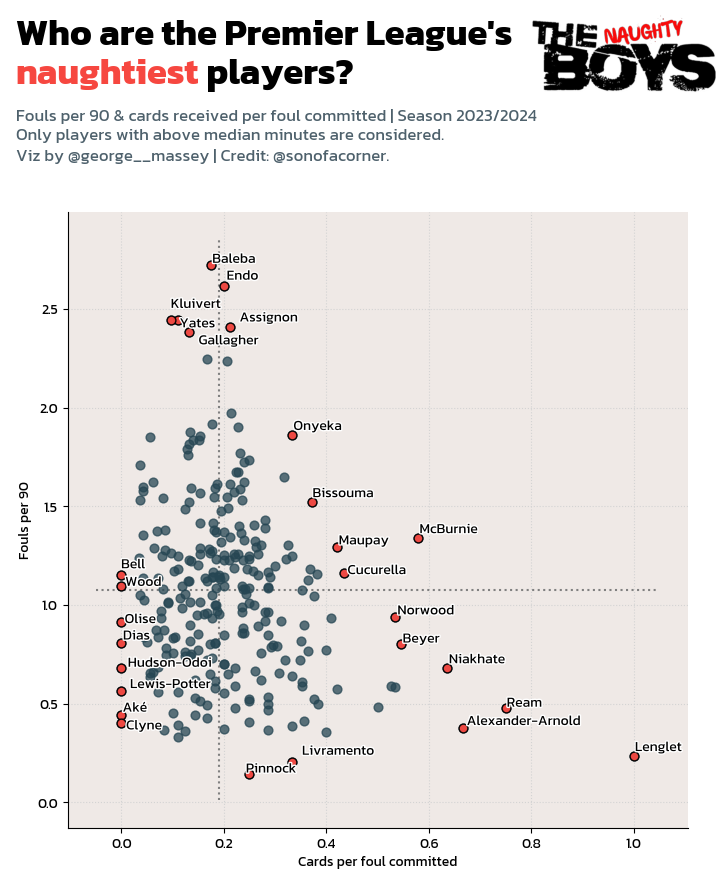

In [336]:
fig = plt.figure(figsize = (8,8), dpi = 100)
ax = plt.subplot(facecolor = "#EFE9E6")

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

ax.scatter(
    df["cards_per_fouls"], 
    df["fouls_per_90"], 
    s = 40, 
    alpha = 0.75, 
    color = "#264653",
    zorder = 3
)

ax.scatter(
    annotated_df["cards_per_fouls"], 
    annotated_df["fouls_per_90"], 
    s = 40, 
    alpha = 0.95, 
    color = "#F64740",
    zorder = 3,
    ec = "#000000",
)

ax.plot(
    [df["cards_per_fouls"].median(), df["cards_per_fouls"].median()],
    [ax.get_ylim()[0], ax.get_ylim()[1]], 
    ls = ":",
    color = "gray",
    zorder = 2
)

ax.plot(
    [ax.get_xlim()[0], ax.get_xlim()[1]],
    [df["fouls_per_90"].median(), df["fouls_per_90"].median()], 
    ls = ":",
    color = "gray",
    zorder = 2
)

ax.grid(True, ls = ":", color = "lightgray")

texts = []
for index in range(annotated_df.shape[0]):
    texts += [
        ax.text(
            x=annotated_df['cards_per_fouls'].iloc[index], y=annotated_df['fouls_per_90'].iloc[index],
            s=annotated_df['Player'].iloc[index],
            path_effects=[path_effects.Stroke(linewidth=2, foreground=fig.get_facecolor()), 
            path_effects.Normal()], color='black',
            fontproperties = regular, weight='bold'
        )
    ]

adjust_text(texts, only_move={'points':'y', 'text':'xy', 'objects':'xy'})

ax.set_xlabel("Cards per foul committed", fontproperties = regular)
ax.set_ylabel("Fouls per 90", fontproperties = regular)
# Set font properties for x-axis tick labels
for label in ax.get_xticklabels():
    label.set_fontproperties(regular)

# Set font properties for y-axis tick labels
for label in ax.get_yticklabels():
    label.set_fontproperties(regular)

# # ---- The Naught Boys Image
league_icon = Image.open(r"C:\Users\George\Downloads\naughty.png")
league_ax = fig.add_axes([0.705, 0.96, 0.23, 0.23], zorder=1)
league_ax.imshow(league_icon)
league_ax.axis("off")


fig_text(
    x = .06, y = 1.03, 
    s = f"Who are the {league_name}'s\n<naughtiest> players?",
    highlight_textprops=[{"color":"#F64740", "style":"italic"}],
    va = "bottom", ha = "left",
    fontsize = 26, color = "black", fontproperties= bold
)

fig_text(
	x = .06, y = .94, 
    s = "Fouls per 90 & cards received per foul committed | Season 2023/2024\nOnly players with above median minutes are considered.\nViz by @george__massey | Credit: @sonofacorner.",
	va = "bottom", ha = "left",
	fontsize = 12, color = "#4E616C", fontproperties= regular
)


plt.savefig(
	f"C:\\Users\\George\\Documents\\Football Analytics\\Visuals\\{league_name} Naughty Boys.png",
	dpi = 600,
	facecolor = "#EFE9E6",
	bbox_inches="tight",
    edgecolor="none",
	transparent = False
)

